# Read in the data

In [3]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [4]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [5]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [6]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [7]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [8]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [9]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [10]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [11]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [12]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

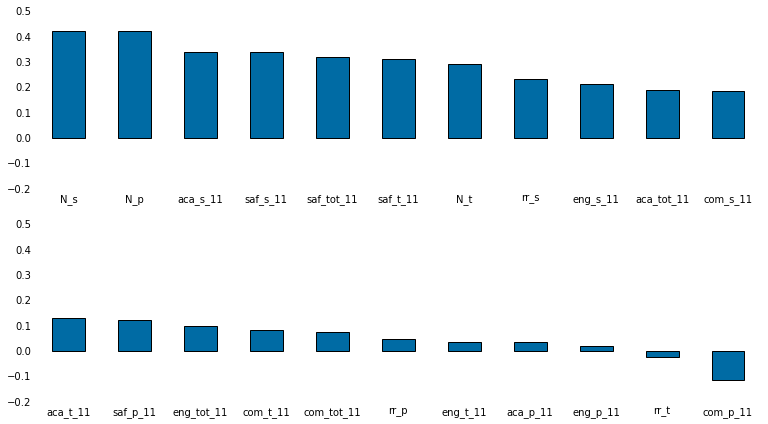

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
survey_correlations = correlations[survey_fields].sort_values(ascending=False)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(11,10))

ax1 = survey_correlations[0:11].plot(
    ax = axes[0],
    kind='bar', 
    color=(0, 107/255, 164/255),
     rot = 360,
    figsize=(13,7)
    )

ax2 = survey_correlations[11:22].plot(
    ax = axes[1],
    kind='bar', 
    color=(0, 107/255, 164/255),
     rot = 360,
    figsize=(13,7)
    )

ax2.set_ylim([-0.2,0.5])
ax1.set_ylim([-0.2,0.5])

for ax in axes:
    ax.tick_params(bottom="off", left="off", top="off", right="off")
    for key, spine in ax.spines.items():
        spine.set_visible(False)


plt.show()

N_s         :	Number of student respondents  
0.423463
  
N_p	        :   Number of parent respondents  
0.421530  

aca_s_11	:   Academic expectations score based on student responses  
0.339435

saf_s_11	:   Safety and Respect score based on student responses  
0.337639
  
saf_tot_11  :	Safety and Respect total score   
0.318753 

saf_t_11	:   Safety and Respect score based on teacher responses  
0.313810  

N_t         :	Number of teacher respondents   
0.291463  

rr_s        :	Student Response Rate   
0.232199 

eng_s_11	:   Engagement score based on student responses   
0.213822

aca_tot_11	:   Academic Expectations total score  
0.190966

com_s_11	:   Communication score based on student responses  
0.187370  

aca_t_10	:   Academic expectations score based on teacher responses  
0.132348

saf_p_10    :	Safety and Respect score based on parent responses   
0.122913  

eng_tot_10  :	Engagement total score  
0.100102  

com_t_10    :   Communication score based on teacher responses  
0.082419

com_tot_10  :	Communication total score  
0.082419

rr_p        :	Parent Response Rate    
0.047925  

eng_t_11    :   Engagement score based on teacher responses   
0.036906  

aca_p_10    :	Academic expectations score based on parent responses  
0.035155

eng_p_10    :	Engagement score based on parent responses  
0.020254

rr_t        :	Teacher Response Rate    
-0.023386  

com_p_10    :	Communication score based on parent responses  
-0.115073

## Analysing Survey Correlations

The size of the school has the highest correlation to high SAT scores.

Below that, the students own academic expectations, as well as how safe and respected they feel in the school are the next most important predictors.

The total Safety and Respect score and teacher Safety and Respect score are next.

The number of teachers who responded had a high correlation, but the teacher response rate correlation was almost 0.

Other than Safety and Respect scores, the parent scores had very low correlation to results.

The parent Communication score had an inverse correlation to SAT results, which is surprising.

## Safety vs SAT Scores

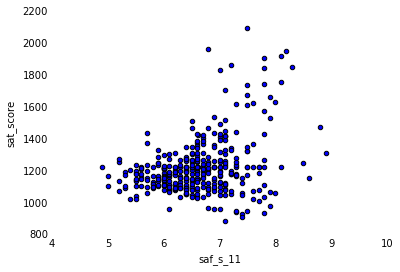

In [14]:
ax = combined.plot(kind='scatter', x='saf_s_11', y='sat_score')

ax.tick_params(bottom="off", left="off", top="off", right="off")
for key, spine in ax.spines.items():
        spine.set_visible(False)

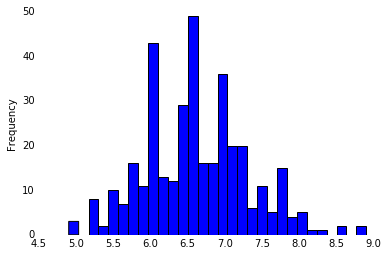

In [29]:
ax = combined['saf_s_11'].plot(kind='hist', bins=30)
ax.tick_params(bottom="off", left="off", top="off", right="off")
for key, spine in ax.spines.items():
        spine.set_visible(False)

In [16]:
combined['saf_s_11'].mean()

6.611666666666666

Below a safety score of around 6.6, the max SAT score is 1600. 
6.6 is roughly the halfway point of the safety scores


However a high safety score does not decrease the number of low SAT results, rather it increases the range.

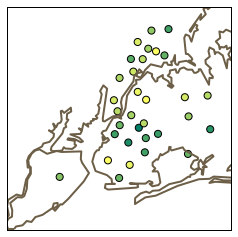

In [21]:
import numpy as np
from mpl_toolkits.basemap import Basemap

districts = combined.groupby('school_dist').agg(np.mean)
districts.reset_index(inplace=True)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution = 'h'
)

m.scatter(longitudes, 
          latitudes, 
          s=50,
          zorder=2, 
          latlon=True, 
          c=districts['saf_s_11'],
          cmap='summer'
         )

m.drawmapboundary(fill_color='#FFFFFF')
m.drawcoastlines(color='#6D5F47', linewidth=2)


plt.show()

Green school districts have low school safety.  
The border of Manhatten and Queens has the worst safety levels.  
Generally, the further from the centre, the higher the safety


## Race vs SAT

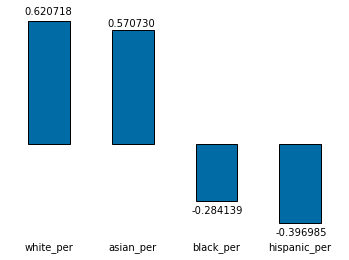

In [53]:
columns = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
race_corr = correlations[columns]
ax = race_corr.plot(kind='bar', color=(0, 107/255, 164/255), rot=360)
ax.set_ylim([-0.47,0.65])

ax.tick_params(bottom="off", left="off", top="off", right="off")
for key, spine in ax.spines.items():
        spine.set_visible(False)
        
ax.yaxis.set_ticklabels([])
ax.text(-0.3,0.65, '0.620718')
ax.text(0.7,0.59, '0.570730')
ax.text(1.7,-0.35, '-0.284139')
ax.text(2.7,-0.46, '-0.396985')

The white and asian students do better than the black and hispanic students on the SAT

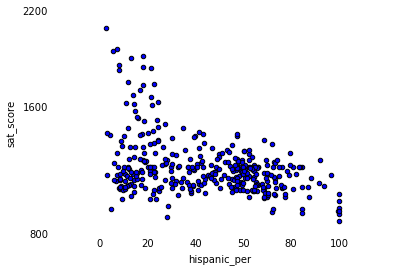

In [58]:
ax = combined.plot(kind='scatter', x='hispanic_per', y='sat_score')
ax.tick_params(bottom="off", left="off", top="off", right="off")
for key, spine in ax.spines.items():
        spine.set_visible(False)
        
ax.yaxis.set_ticklabels([800,'','','',1600,'','',2200])
ax.xaxis.set_ticklabels(['',0, 20, 40, 50, 80, 100])

In [66]:
mask = combined['hispanic_per'] > 95
combined.loc[mask, 'sat_score'].describe()

count       8.000000
mean      992.375000
std        89.600602
min       887.000000
25%       946.750000
50%       960.500000
75%      1025.000000
max      1174.000000
Name: sat_score, dtype: float64

Once a school is more than approximately 20% hispanic, the SAT score upper range drops dramatically, then decays much slower.

At 100% hispanic, the mean is 992.38 with a standard deviation of 89.6

In [67]:
combined.loc[mask, 'SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [68]:
mask = combined['hispanic_per'] < 10
combined.loc[mask, 'SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
192                          BEDFORD ACADEMY HIGH SCHOOL
194                            BENJAMIN BANNEKER ACADEMY
220                           BOYS AND GIRLS HIGH SCHOOL
223    ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...
226               THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP
227                         SCHOOL FOR HUMAN RIGHTS, THE
228                  SCHOOL FOR DEMOCRACY AND LEADERSHIP
229    HIGH SCHOOL FOR YOUTH AND COMMUNITY DEVELOPMEN...
230        HIGH SCHOOL FOR SERVICE & LEARNING AT ERASMUS
231    SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE...
235              MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
236                             CLARA BARTON HIGH SCHOOL
237                           IT TAKES A VILLAGE ACADEMY
238                           B

The high percentage Hispanic schools often don't have a dedicated website.  
The low percentage hispanic schools have more of a focus on students being college bound.

## Gender vs SAT

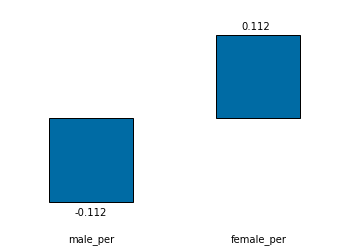

In [79]:
columns = ['male_per', 'female_per']
gender_corr = correlations[columns]

ax = gender_corr.plot(kind='bar', color=(0, 107/255, 164/255), rot=360)
ax.tick_params(bottom="off", left="off", top="off", right="off")
for key, spine in ax.spines.items():
        spine.set_visible(False)
        
ax.yaxis.set_ticklabels([])
ax.text(-0.1,-0.13, '-0.112')
ax.text(0.9,0.12, '0.112')

Women on average do better on the SAT

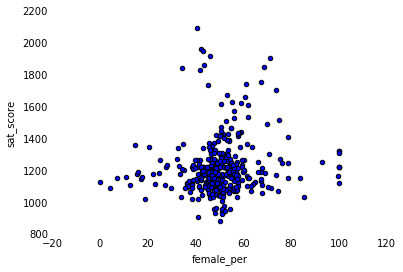

In [83]:
ax = combined.plot(kind='scatter', x='female_per', y='sat_score')
ax.tick_params(bottom="off", left="off", top="off", right="off")
for key, spine in ax.spines.items():
        spine.set_visible(False)

Rather than the schools with more women achieving the highest average SAT scores, there is less of a jump between the high and low scores.  
More male schools appear to do averagely or extremely well, with very few schools doing a normal amount above average.  
Schools with more women have lower highs but more above the average mark

In [85]:
mask = (combined['female_per'] > 60) & (combined['sat_score'] > 1700)
combined.loc[mask, 'SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These 5 schools are an eclectic mix - Townsend Harris has incredibly high admission competition, while Beacon and Fiorello H. LaGuardia are both perfoming/arts schools.

## AP vs SAT 

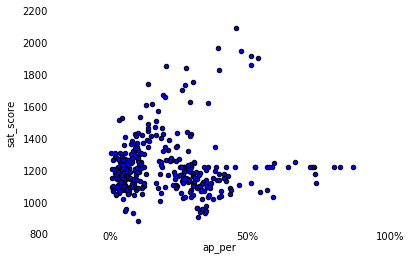

In [102]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

ax = combined.plot(kind='scatter', x='ap_per', y='sat_score')
ax.tick_params(bottom="off", left="off", top="off", right="off")
for key, spine in ax.spines.items():
        spine.set_visible(False)
        
ax.xaxis.set_ticklabels([])
ax.text(-0.02,770, '0%')
ax.text(0.46,770, '50%')
ax.text(0.96,770, '100%')

The highest SAT score increases as the percentage of AP test takers increases up to roughly 50% - afterwards, it dramatically drops off.

Possibly due to increased class sizes? However the number of schools with over 50% is very low

## Class Size vs SAT

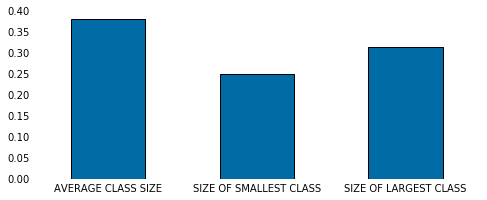

In [109]:
columns = (['AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS', 
            'SIZE OF LARGEST CLASS'])
class_corr = correlations[columns]

ax = class_corr.plot(kind='bar', color=(0, 107/255, 164/255), rot=360, 
                    figsize=[8,3])
ax.tick_params(bottom="off", left="off", top="off", right="off")
for key, spine in ax.spines.items():
        spine.set_visible(False)

(5, 60)

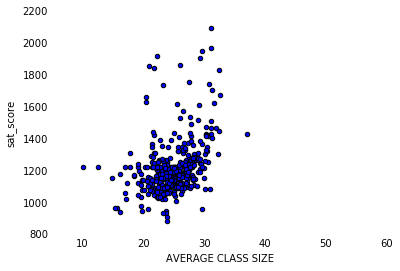

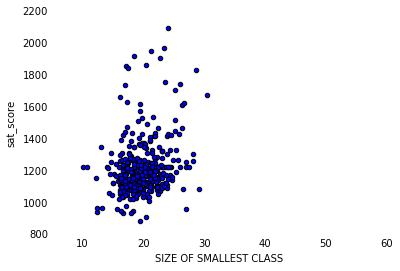

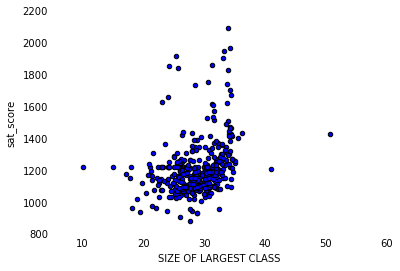

In [118]:
ax = combined.plot(kind='scatter', x='AVERAGE CLASS SIZE', y='sat_score')
ax.tick_params(bottom="off", left="off", top="off", right="off")
for key, spine in ax.spines.items():
        spine.set_visible(False)
ax.set_xlim([5,60])
        
ax = combined.plot(kind='scatter', x='SIZE OF SMALLEST CLASS', y='sat_score')
ax.tick_params(bottom="off", left="off", top="off", right="off")
for key, spine in ax.spines.items():
        spine.set_visible(False)
ax.set_xlim([5,60])

ax = combined.plot(kind='scatter', x='SIZE OF LARGEST CLASS', y='sat_score')
ax.tick_params(bottom="off", left="off", top="off", right="off")
for key, spine in ax.spines.items():
        spine.set_visible(False)
ax.set_xlim([5,60])

Class sizes below 20 seem to correlate to a lower SAT Score.
Class size is generally capped at 30 and this is the class size in which students do the best at